In [ ]:
##기존 데이터
import pandas as pd

df = pd.DataFrame({
    "order_id": ["O001","O002","O003","O004","O005","O006"],
    "date": ["2026-01-01","2026-01-02","2026-01-03","2026-01-04","2026-01-05","2026-01-06"],
    "store": ["A","A","B","A","B","A"],
    "menu": ["Latte","Americano","Mocha","Latte","Americano","Mocha"],
    "price": [5000,4500,5500,5000,4500,5500],
    "qty": [1,2,1,3,1,2],
    "paid": [True, True, False, True, True, False]
})

df["date"] = pd.to_datetime(df["date"])
df


,order_id,date,store,menu,price,qty,paid
0,O001,2026-01-01,A,Latte,5000,1,True
1,O002,2026-01-02,A,Americano,4500,2,True
2,O003,2026-01-03,B,Mocha,5500,1,False
3,O004,2026-01-04,A,Latte,5000,3,True
4,O005,2026-01-05,B,Americano,4500,1,True
5,O006,2026-01-06,A,Mocha,5500,2,False


In [ ]:
#####데이터 확장
#customer_id 추가 (재구매 구조 만들기)
df["customer_id"] = ["C01","C01","C02","C01","C02","C03"]

#C01 → 여러 번 주문
#C02 → 여러 번 주
#C03 → 1회성 고객

In [ ]:
#날짜를 여러 달로 분산
df.loc[df["order_id"] == "O004", "date"] = "2026-02-10"
df.loc[df["order_id"] == "O005", "date"] = "2026-02-18"
df.loc[df["order_id"] == "O006", "date"] = "2026-03-05"

df["date"] = pd.to_datetime(df["date"])
df

#이제 재구매 + 시간 경과 구조 OK

,order_id,date,store,menu,price,qty,paid,customer_id
0,O001,2026-01-01,A,Latte,5000,1,True,C01
1,O002,2026-01-02,A,Americano,4500,2,True,C01
2,O003,2026-01-03,B,Mocha,5500,1,False,C02
3,O004,2026-02-10,A,Latte,5000,3,True,C01
4,O005,2026-02-18,B,Americano,4500,1,True,C02
5,O006,2026-03-05,A,Mocha,5500,2,False,C03


In [ ]:
###코호트 분석 시작
#주문 월 컬럼 생성
df["order_month"] = df["date"].dt.to_period("M")


In [ ]:
#고객별 첫 방문 월 (코호트 기준)
df["first_visit_month"] = (
    df.groupby("customer_id")["order_month"]
      .transform("min")
)

#이게 코호트 그룹

In [ ]:
###코호트 집계 테이블 만들기
#코호트 x 주문월별 고객수

cohort_data = (
    df.groupby(["first_visit_month", "order_month"])
      .agg(n_customers=("customer_id", "nunique"))
      .reset_index()
)

cohort_data



,first_visit_month,order_month,n_customers
0,2026-01,2026-01,2
1,2026-01,2026-02,2
2,2026-03,2026-03,1


In [ ]:
#기간 번호 계산 (n개월 차)
cohort_data["period_number"] = (
    cohort_data["order_month"] - cohort_data["first_visit_month"]
).apply(lambda x: x.n)

cohort_data
#0 = 첫 구매 월
#1 = 1개월 뒤
#2 = 2개월 뒤

,first_visit_month,order_month,n_customers,period_number
0,2026-01,2026-01,2,0
1,2026-01,2026-02,2,1
2,2026-03,2026-03,1,0


In [ ]:
##코호트 피벗 테이블 (최종 결과)
cohort_pivot = cohort_data.pivot_table(
    index="first_visit_month",
    columns="period_number",
    values="n_customers"
)

cohort_pivot


period_number,0,1
first_visit_month,,
2026-01,2.0,2.0
2026-03,1.0,NaN


In [ ]:
#### +++ 리텐션 비율로 바꾸기
retention = cohort_pivot.divide(cohort_pivot[0], axis=0)    #n개월차 인원 / 첫 달 인원
retention

#첫 달 대비 몇 %가 남았지?
## -> 각 코호트의 첫 방문자 수를 100%로 놓고
## -> n개월 후에도 살아있는 비율을 계산한 것

period_number,0,1
first_visit_month,,
2026-01,1.0,1.0
2026-03,1.0,NaN


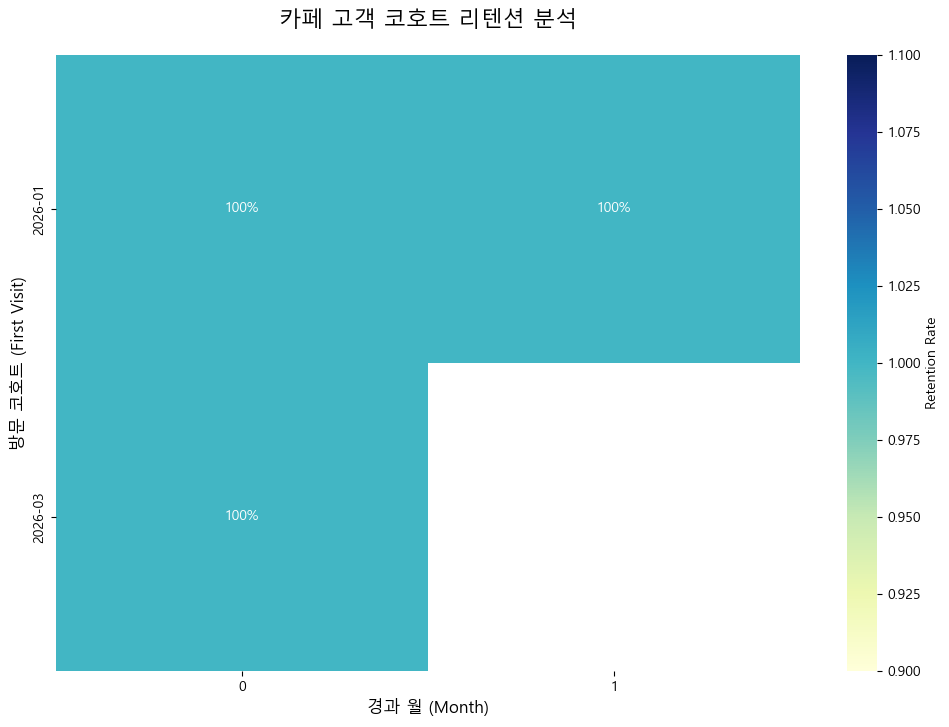

In [ ]:
########## 시각화까지?!?!?
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 한글 깨짐 방지 설정 (필요 시)
plt.rc('font', family='Malgun Gothic') # Windows
# plt.rc('font', family='AppleGothic') # Mac
plt.rcParams['axes.unicode_minus'] = False

# 2. 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(retention, 
            annot=True,          # 숫자 표시
            fmt='.0%',           # 백분율 형식
            cmap='YlGnBu',       # 노랑-초록-파랑 색상 조합
            cbar_kws={'label': 'Retention Rate'})

plt.title('카페 고객 코호트 리텐션 분석', fontsize=16, pad=20)
plt.xlabel('경과 월 (Month)', fontsize=12)
plt.ylabel('방문 코호트 (First Visit)', fontsize=12)

plt.show()

In [ ]:
print("sonamu")

sonamu


In [ ]:
#!python -m jupyter nbconvert --to markdown 03_01_cafe_data_cohort.ipynb